# STEP 0: Install Dependencies

In [ ]:
!pip install numpy scipy pandas matplotlib seaborn mne pyedflib \
    scikit-learn torch torchvision torchaudio \
    tqdm wfdb h5py pyyaml joblib \
    einops --quiet


# STEP 1: Mount Google Drive

In [42]:
from pathlib import Path
from google.colab import drive

DRIVE_PATH = Path("/content/drive/MyDrive")
BASE_DIR = DRIVE_PATH / "sleep_edf_expanded"

if not BASE_DIR.exists():
    drive.mount('/content/drive')
    BASE_DIR.mkdir(parents=True, exist_ok=True)
    print("Drive mounted and base directory created:", BASE_DIR)
else:
    print("Base directory exists:", BASE_DIR)

Base directory exists: /content/drive/MyDrive/sleep_edf_expanded


# STEP 2: Download Dataset (if not present)

In [43]:
ZIP_PATH = "/content/sleep-edf.zip"
DATA_URL = "https://physionet.org/static/published-projects/sleep-edfx/sleep-edf-database-expanded-1.0.0.zip"

if not (BASE_DIR / "sleep-edf-database-expanded-1.0.0").exists():
    !wget -O "{ZIP_PATH}" "{DATA_URL}"
    !unzip -q "{ZIP_PATH}" -d "{BASE_DIR}"
    print("Dataset downloaded and unzipped")
else:
    print("Dataset already exists, skipping download")


Dataset already exists, skipping download


**Visualize Dataset Directory Structure**

In [44]:
from pathlib import Path

DATASET_DIR = BASE_DIR / "sleep-edf-database-expanded-1.0.0"

# Show top-level folders
print("Top-level folders:")
for p in DATASET_DIR.iterdir():
    if p.is_dir():
        print(" -", p.name)


Top-level folders:
 - sleep-cassette
 - sleep-telemetry
 - preprocessed


**Count PSG and Hypnogram Files**

In [45]:
psg_files = list(DATASET_DIR.rglob("*-PSG.edf"))
hyp_files = list(DATASET_DIR.rglob("*-Hypnogram.edf"))

print("Total PSG files       :", len(psg_files))
print("Total Hypnogram files :", len(hyp_files))


Total PSG files       : 197
Total Hypnogram files : 197


In [47]:
from collections import Counter

def extract_subject_id(filename):
    return Path(filename).stem[:7].upper()

subject_ids = [extract_subject_id(f) for f in psg_files]
subject_counts = Counter(subject_ids)

print("Total unique subjects:", len(subject_counts))
print("\nSubjects with multiple recordings:")

for sid, cnt in subject_counts.items():
    if cnt > 1:
        print(f"{sid}: {cnt} recordings")
        break


Total unique subjects: 197

Subjects with multiple recordings:


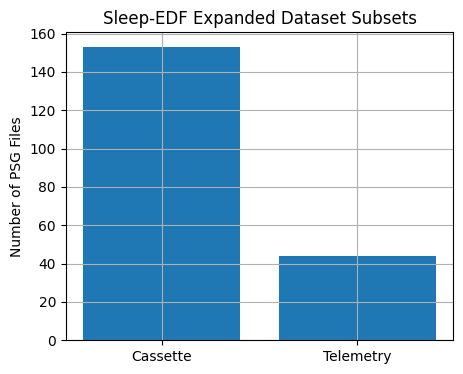

In [51]:
import matplotlib.pyplot as plt

psg_files = list(DATASET_DIR.rglob("*-PSG.edf"))

cassette_psg = [f for f in psg_files if "sleep-cassette" in str(f).lower()]
telemetry_psg = [f for f in psg_files if "sleep-telemetry" in str(f).lower()]


labels = ["Cassette", "Telemetry"]
counts = [len(cassette_psg), len(telemetry_psg)]

plt.figure(figsize=(5,4))
plt.bar(labels, counts)
plt.ylabel("Number of PSG Files")
plt.title("Sleep-EDF Expanded Dataset Subsets")
plt.grid(True)
plt.show()


# STEP 3: Pair PSG and Hypnogram files

In [52]:
import json
from pathlib import Path

DATASET_DIR = BASE_DIR / "sleep-edf-database-expanded-1.0.0"

psg_files = list(DATASET_DIR.rglob("*-PSG.edf"))
hyp_files = list(DATASET_DIR.rglob("*-Hypnogram.edf"))

def extract_subject_id(filename):
    return Path(filename).stem[:7].upper()

psg_map = {extract_subject_id(f): str(f) for f in psg_files}
hyp_map = {extract_subject_id(f): str(f) for f in hyp_files}

pairs, missing_psg, missing_hyp = [], [], []

all_ids = sorted(set(psg_map.keys()) | set(hyp_map.keys()))
for rid in all_ids:
    psg = psg_map.get(rid)
    hyp = hyp_map.get(rid)
    if psg and hyp:
        pairs.append({"record_id": rid, "psg_file": psg, "hypnogram_file": hyp})
    elif psg and not hyp:
        missing_hyp.append(rid)
    elif hyp and not psg:
        missing_psg.append(rid)

OUT_JSON = DATASET_DIR / "paired_files.json"
with open(OUT_JSON, "w") as f:
    json.dump({
        "total_psg": len(psg_files),
        "total_hyp": len(hyp_files),
        "paired_records": len(pairs),
        "missing_psg": missing_psg,
        "missing_hyp": missing_hyp,
        "pairs": pairs
    }, f, indent=2)

print(f"Total paired records: {len(pairs)}, Missing PSG: {len(missing_psg)}, Missing Hyp: {len(missing_hyp)}")

Total paired records: 197, Missing PSG: 0, Missing Hyp: 0


**Pick ONE sample PSG–Hypnogram pair**

In [54]:
import json
from pathlib import Path
from pprint import pprint  # for clean printing

DATASET_DIR = BASE_DIR / "sleep-edf-database-expanded-1.0.0"

with open(DATASET_DIR / "paired_files.json", "r") as f:
    data = json.load(f)

print("Keys in paired_files.json:")
print(data.keys())

print("\nTotal paired records:", len(data["pairs"]))

print("\nFirst paired record (FULL STRUCTURE):")
pprint(data["pairs"][0])


Keys in paired_files.json:
dict_keys(['total_psg', 'total_hyp', 'paired_records', 'missing_psg', 'missing_hyp', 'pairs'])

Total paired records: 197

First paired record (FULL STRUCTURE):
{'hypnogram_file': '/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf',
 'psg_file': '/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf',
 'record_id': 'SC4001E'}


In [55]:
sample = data["pairs"][0]

psg_path = Path(sample["psg_file"])
hyp_path = Path(sample["hypnogram_file"])

print("===== SAMPLE DATA PAIR =====")
print(f"Subject ID      : {sample['record_id']}")
print(f"PSG file name   : {psg_path.name}")
print(f"PSG full path  : {psg_path}")
print()
print(f"Hypnogram name : {hyp_path.name}")
print(f"Hypnogram path : {hyp_path}")


===== SAMPLE DATA PAIR =====
Subject ID      : SC4001E
PSG file name   : SC4001E0-PSG.edf
PSG full path  : /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf

Hypnogram name : SC4001EC-Hypnogram.edf
Hypnogram path : /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf


In [56]:
print("===== FIRST 5 PSG–HYPNOGRAM PAIRS =====")
for i, pair in enumerate(data["pairs"][:5]):
    psg = Path(pair["psg_file"]).name
    hyp = Path(pair["hypnogram_file"]).name
    print(f"{i+1}. {pair['record_id']} | PSG: {psg} | HYP: {hyp}")


===== FIRST 5 PSG–HYPNOGRAM PAIRS =====
1. SC4001E | PSG: SC4001E0-PSG.edf | HYP: SC4001EC-Hypnogram.edf
2. SC4002E | PSG: SC4002E0-PSG.edf | HYP: SC4002EC-Hypnogram.edf
3. SC4011E | PSG: SC4011E0-PSG.edf | HYP: SC4011EH-Hypnogram.edf
4. SC4012E | PSG: SC4012E0-PSG.edf | HYP: SC4012EC-Hypnogram.edf
5. SC4021E | PSG: SC4021E0-PSG.edf | HYP: SC4021EH-Hypnogram.edf


In [60]:
raw = mne.io.read_raw_edf(psg_path, preload=False, verbose=False)

print("\n===== PSG FILE HEADER =====")
print(raw)



===== PSG FILE HEADER =====
<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~10 KiB, data not loaded>


/tmp/ipython-input-915326795.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False, verbose=False)
/tmp/ipython-input-915326795.py:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False, verbose=False)
/tmp/ipython-input-915326795.py:1: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=False, verbose=False)


In [61]:
print("\nSampling frequency (Hz):", raw.info["sfreq"])
print("Total samples:", raw.n_times)
print("Duration (hours):", raw.n_times / raw.info["sfreq"] / 3600)

print("\nCHANNELS IN PSG FILE:")
for ch in raw.ch_names:
    print(" -", ch)



Sampling frequency (Hz): 100.0
Total samples: 7950000
Duration (hours): 22.083333333333332

CHANNELS IN PSG FILE:
 - EEG Fpz-Cz
 - EEG Pz-Oz
 - EOG horizontal
 - Resp oro-nasal
 - EMG submental
 - Temp rectal
 - Event marker


In [62]:
# Load small portion for inspection
raw_small = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)

# Pick one EEG channel
ch_name = raw_small.ch_names[0]
data, times = raw_small[ch_name, :1000]  # first 1000 samples

print("\n===== PSG SIGNAL RECORDS =====")
print(f"Channel: {ch_name}")
print("First 20 samples:")
print(data[0][:20])


/tmp/ipython-input-2582455710.py:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_small = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-2582455710.py:2: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_small = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-2582455710.py:2: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_small = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)



===== PSG SIGNAL RECORDS =====
Channel: EEG Fpz-Cz
First 20 samples:
[ 5.01684982e-06 -2.57875458e-06  1.35970696e-06 -2.39120879e-06
 -5.20439560e-06 -7.45494505e-06 -8.29890110e-06 -6.89230769e-06
 -3.70402930e-06 -9.84615385e-07  2.20366300e-06  2.01611722e-06
  1.64102564e-06 -2.67252747e-06 -7.97069597e-07  1.35970696e-06
  2.86007326e-06 -2.20366300e-06  5.15750916e-07  5.86080586e-06]


In [63]:
hyp_path = sample["hypnogram_file"]

print("\nHYPNOGRAM FILE PATH:")
print(hyp_path)

ann = mne.read_annotations(hyp_path)

print("\n===== HYPNOGRAM RECORDS =====")
print("Total annotations:", len(ann))



HYPNOGRAM FILE PATH:
/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf

===== HYPNOGRAM RECORDS =====
Total annotations: 154


In [64]:
print("\nFirst 15 hypnogram records:")
for i in range(15):
    print(
        f"Record {i+1:02d} | "
        f"Onset: {ann.onset[i]:7.1f}s | "
        f"Duration: {ann.duration[i]:6.1f}s | "
        f"Stage: {ann.description[i]}"
    )



First 15 hypnogram records:
Record 01 | Onset:     0.0s | Duration: 30630.0s | Stage: Sleep stage W
Record 02 | Onset: 30630.0s | Duration:  120.0s | Stage: Sleep stage 1
Record 03 | Onset: 30750.0s | Duration:  390.0s | Stage: Sleep stage 2
Record 04 | Onset: 31140.0s | Duration:   30.0s | Stage: Sleep stage 3
Record 05 | Onset: 31170.0s | Duration:   30.0s | Stage: Sleep stage 2
Record 06 | Onset: 31200.0s | Duration:  150.0s | Stage: Sleep stage 3
Record 07 | Onset: 31350.0s | Duration:   30.0s | Stage: Sleep stage 4
Record 08 | Onset: 31380.0s | Duration:   60.0s | Stage: Sleep stage 3
Record 09 | Onset: 31440.0s | Duration:   60.0s | Stage: Sleep stage 4
Record 10 | Onset: 31500.0s | Duration:   30.0s | Stage: Sleep stage 3
Record 11 | Onset: 31530.0s | Duration:  120.0s | Stage: Sleep stage 4
Record 12 | Onset: 31650.0s | Duration:   30.0s | Stage: Sleep stage 3
Record 13 | Onset: 31680.0s | Duration:  120.0s | Stage: Sleep stage 4
Record 14 | Onset: 31800.0s | Duration:   30.0s

![FireShot Capture 002 - Model training improvements - [chatgpt.com].png](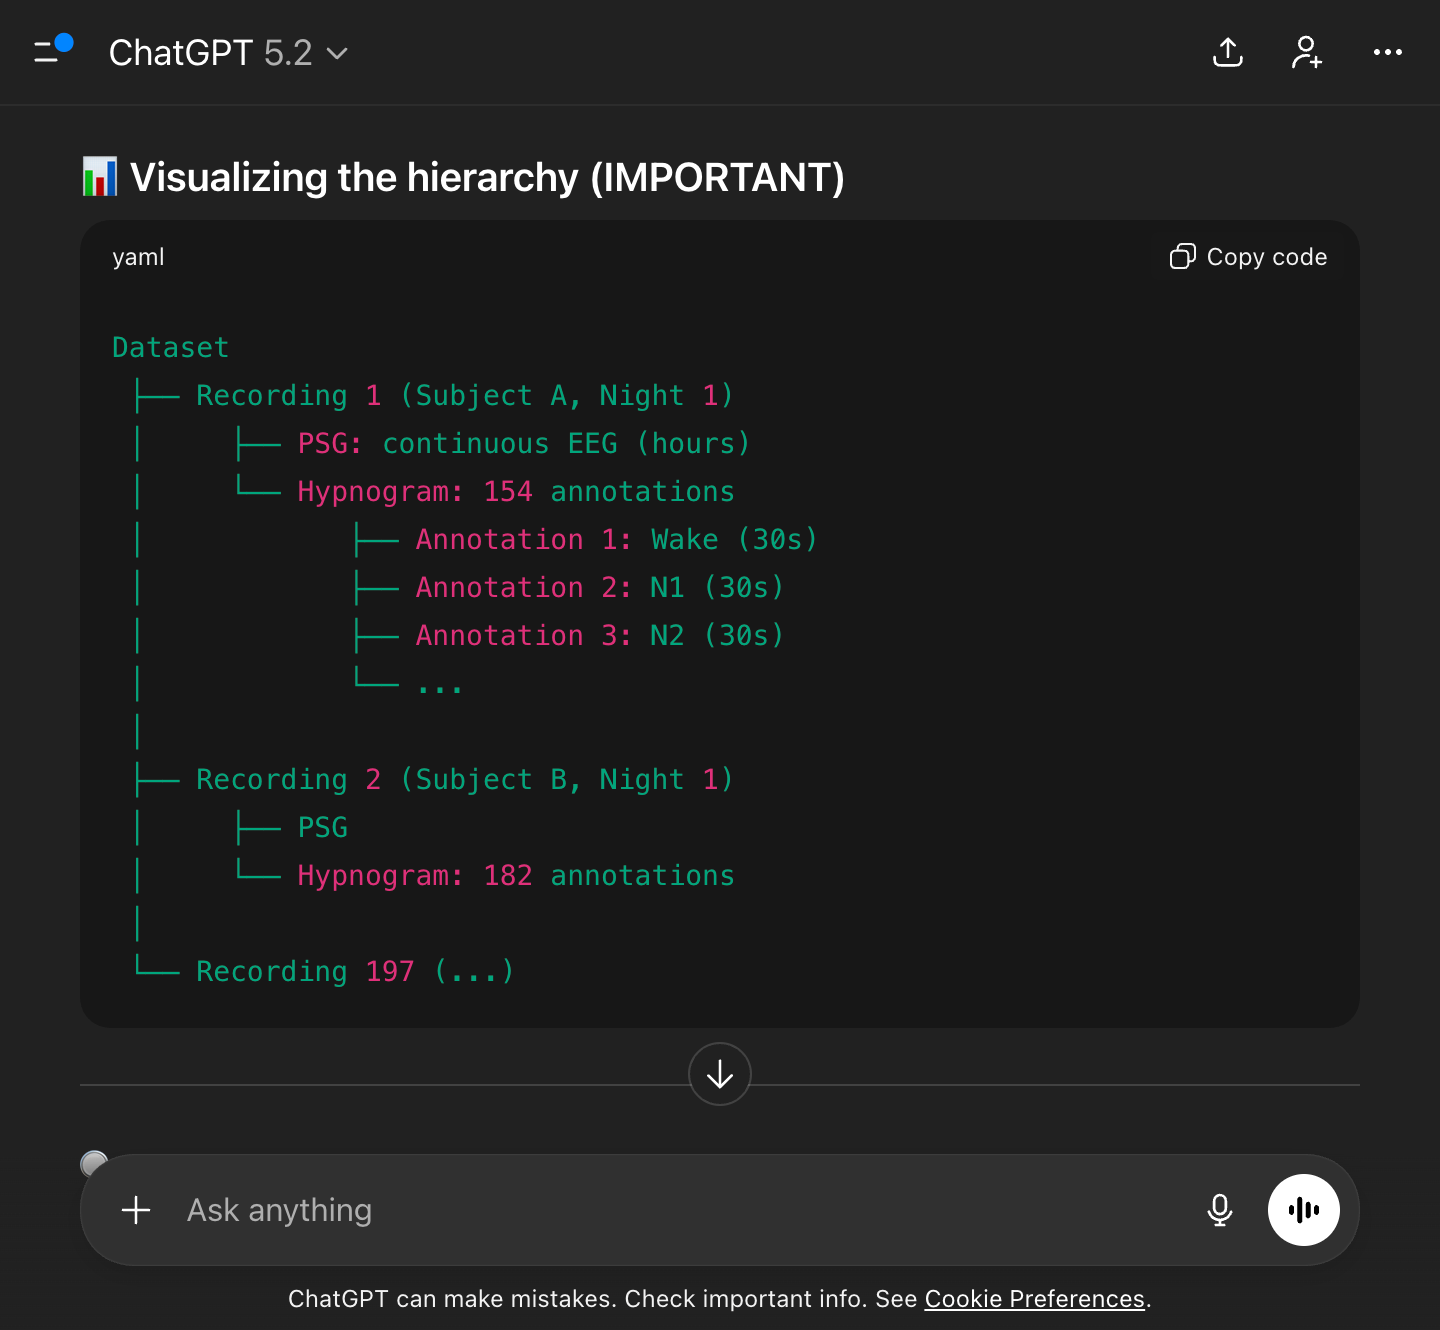)

# STEP 4: Metadata Extraction

In [65]:

import mne
from collections import Counter
from tqdm import tqdm

with open(OUT_JSON, "r") as f:
    paired_data = json.load(f)["pairs"]

metadata = []
agg_stage_counts = Counter()
sfreq_counter = Counter()
channel_sets = Counter()

for pair in tqdm(paired_data, desc="Processing metadata"):
    rid = pair["record_id"]
    entry = {
        "record_id": rid,
        "psg_file": pair["psg_file"],
        "hypnogram_file": pair["hypnogram_file"],
        "channels": None, "n_channels": None,
        "sfreq": None, "duration_sec": None,
        "n_annotations": None, "stage_counts": None,
        "subset": None, "error": None
    }
    try:
        fname = pair["psg_file"].lower()
        entry["subset"] = "sleep-cassette" if "sleep-cassette" in fname else "sleep-telemetry"
        raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False)
        entry["channels"] = raw.ch_names
        entry["n_channels"] = len(raw.ch_names)
        entry["sfreq"] = raw.info.get("sfreq", None)
        sfreq_counter.update([entry["sfreq"]])
        channel_sets.update([tuple(raw.ch_names)])
        entry["duration_sec"] = raw.n_times / raw.info["sfreq"] if raw.n_times and raw.info.get("sfreq") else None

        ann = mne.read_annotations(pair["hypnogram_file"])
        entry["n_annotations"] = len(ann)
        stage_counts = dict(Counter(ann.description))
        entry["stage_counts"] = stage_counts
        agg_stage_counts.update(stage_counts)
    except Exception as e:
        entry["error"] = str(e)
    metadata.append(entry)

OUT_METADATA = DATASET_DIR / "metadata_overview.json"
with open(OUT_METADATA, "w") as f:
    json.dump(metadata, f, indent=2)

Processing metadata:   0%|          | 0/197 [00:00<?, ?it/s]/tmp/ipython-input-1037828454.py:30: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False)
/tmp/ipython-input-1037828454.py:30: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False)
/tmp/ipython-input-1037828454.py:30: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False)
/tmp/ipython-input-1037828454.py:30: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False)
/tmp/ipython-input-1037828454.py:30: RuntimeWarning: Channels co

In [66]:
import json
from pathlib import Path

with open(OUT_METADATA, "r") as f:
    metadata = json.load(f)

print("Total metadata entries:", len(metadata))


Total metadata entries: 197


Sampling frequency distribution:
100.0 Hz → 197 recordings


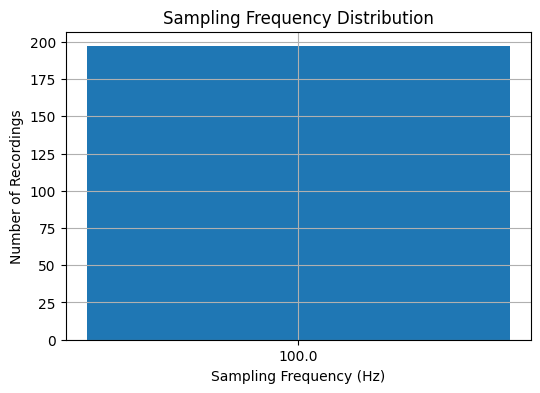

In [67]:
from collections import Counter
import matplotlib.pyplot as plt

sfreqs = [m["sfreq"] for m in metadata if m["sfreq"] is not None]
sfreq_counter = Counter(sfreqs)

print("Sampling frequency distribution:")
for sf, cnt in sfreq_counter.items():
    print(f"{sf} Hz → {cnt} recordings")

plt.figure(figsize=(6,4))
plt.bar([str(k) for k in sfreq_counter.keys()], sfreq_counter.values())
plt.xlabel("Sampling Frequency (Hz)")
plt.ylabel("Number of Recordings")
plt.title("Sampling Frequency Distribution")
plt.grid(True)
plt.show()


Min duration (hours): 7.4944444444444445
Max duration (hours): 24.0
Average duration (hours): 19.53825437112239


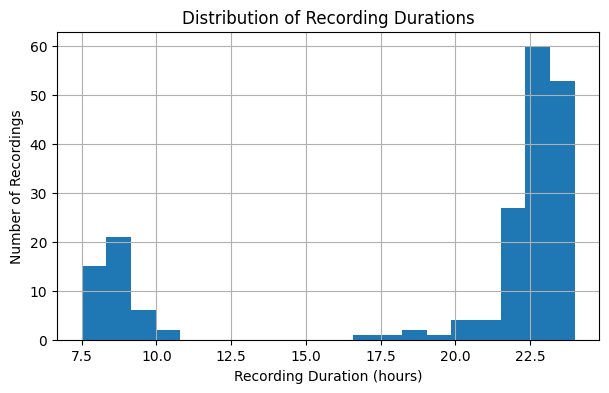

In [68]:
durations_hr = [
    m["duration_sec"] / 3600
    for m in metadata
    if m["duration_sec"] is not None
]

print("Min duration (hours):", min(durations_hr))
print("Max duration (hours):", max(durations_hr))
print("Average duration (hours):", sum(durations_hr) / len(durations_hr))

plt.figure(figsize=(7,4))
plt.hist(durations_hr, bins=20)
plt.xlabel("Recording Duration (hours)")
plt.ylabel("Number of Recordings")
plt.title("Distribution of Recording Durations")
plt.grid(True)
plt.show()


In [69]:
channel_sets = Counter(tuple(m["channels"]) for m in metadata if m["channels"])

print("Unique channel configurations:", len(channel_sets))
print("\nMost common channel set:")
print(channel_sets.most_common(1))


Unique channel configurations: 2

Most common channel set:
[(('EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'), 153)]


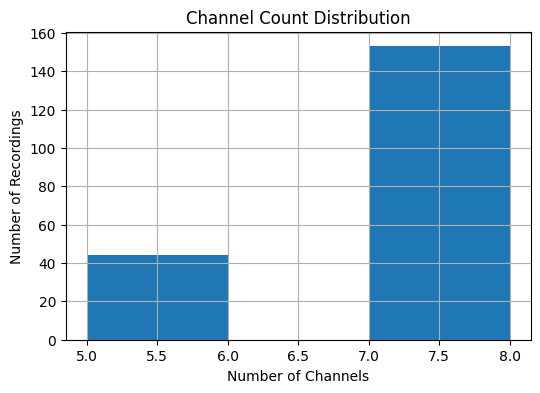

In [70]:
n_channels = [m["n_channels"] for m in metadata if m["n_channels"] is not None]

plt.figure(figsize=(6,4))
plt.hist(n_channels, bins=range(min(n_channels), max(n_channels)+2))
plt.xlabel("Number of Channels")
plt.ylabel("Number of Recordings")
plt.title("Channel Count Distribution")
plt.grid(True)
plt.show()


Min annotations: 47
Max annotations: 401
Average annotations: 144.81725888324874


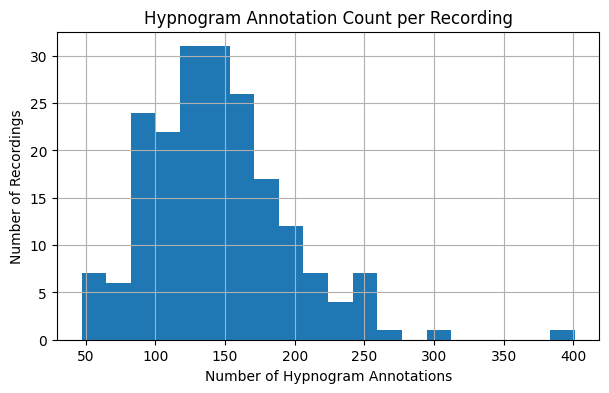

In [71]:
n_annotations = [m["n_annotations"] for m in metadata if m["n_annotations"] is not None]

print("Min annotations:", min(n_annotations))
print("Max annotations:", max(n_annotations))
print("Average annotations:", sum(n_annotations) / len(n_annotations))

plt.figure(figsize=(7,4))
plt.hist(n_annotations, bins=20)
plt.xlabel("Number of Hypnogram Annotations")
plt.ylabel("Number of Recordings")
plt.title("Hypnogram Annotation Count per Recording")
plt.grid(True)
plt.show()


In [72]:
from collections import Counter

agg_stage_counts = Counter()

for m in metadata:
    if m["stage_counts"]:
        agg_stage_counts.update(m["stage_counts"])

print("Aggregate stage counts:")
for k, v in agg_stage_counts.items():
    print(f"{k}: {v}")


Aggregate stage counts:
Sleep stage W: 4461
Sleep stage 1: 7292
Sleep stage 2: 8171
Sleep stage 3: 4820
Sleep stage 4: 1462
Sleep stage R: 1953
Sleep stage ?: 174
Movement time: 196


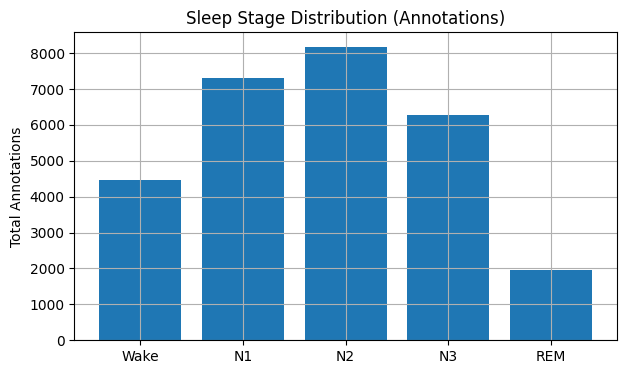

In [73]:
stage_map = {
    "Sleep stage W": "Wake",
    "Sleep stage 1": "N1",
    "Sleep stage 2": "N2",
    "Sleep stage 3": "N3",
    "Sleep stage 4": "N3",
    "Sleep stage R": "REM"
}

mapped_counts = Counter()
for stage, cnt in agg_stage_counts.items():
    if stage in stage_map:
        mapped_counts[stage_map[stage]] += cnt

plt.figure(figsize=(7,4))
plt.bar(mapped_counts.keys(), mapped_counts.values())
plt.ylabel("Total Annotations")
plt.title("Sleep Stage Distribution (Annotations)")
plt.grid(True)
plt.show()


Subset distribution: Counter({'sleep-cassette': 153, 'sleep-telemetry': 44})


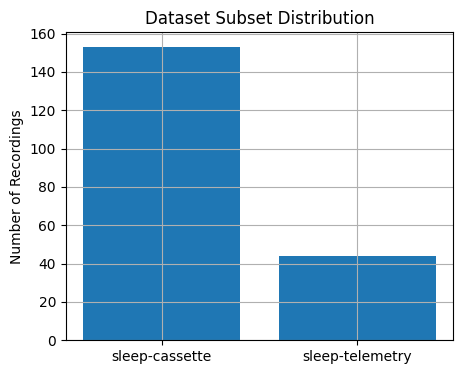

In [74]:
subset_counts = Counter(m["subset"] for m in metadata if m["subset"])

print("Subset distribution:", subset_counts)

plt.figure(figsize=(5,4))
plt.bar(subset_counts.keys(), subset_counts.values())
plt.ylabel("Number of Recordings")
plt.title("Dataset Subset Distribution")
plt.grid(True)
plt.show()


/tmp/ipython-input-2940578288.py:13: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-2940578288.py:13: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-2940578288.py:13: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Plotting PSG channels: []
Using matplotlib as 2D backend.


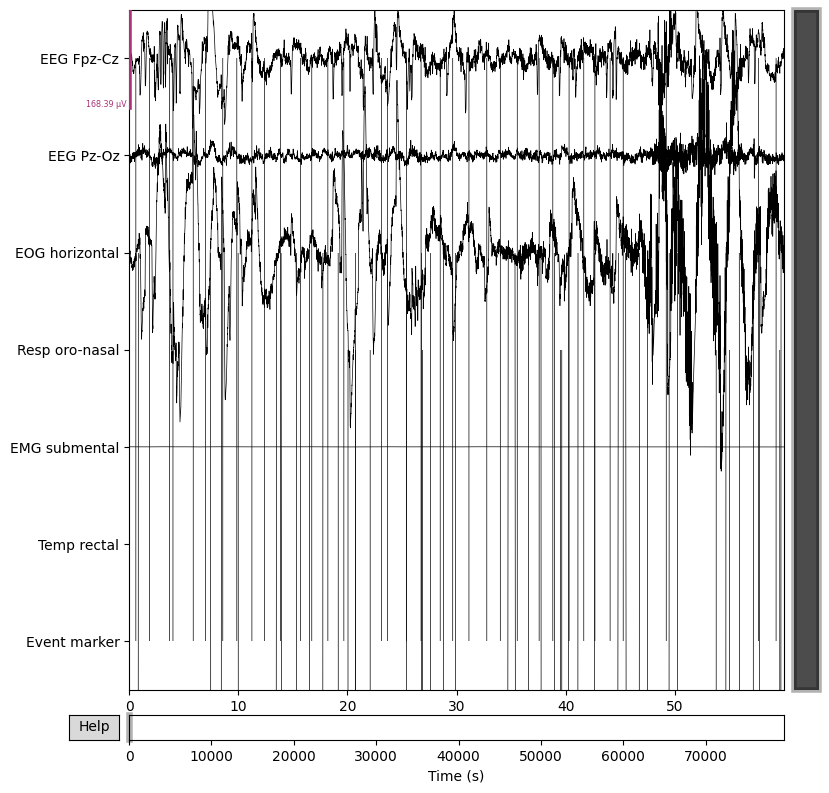

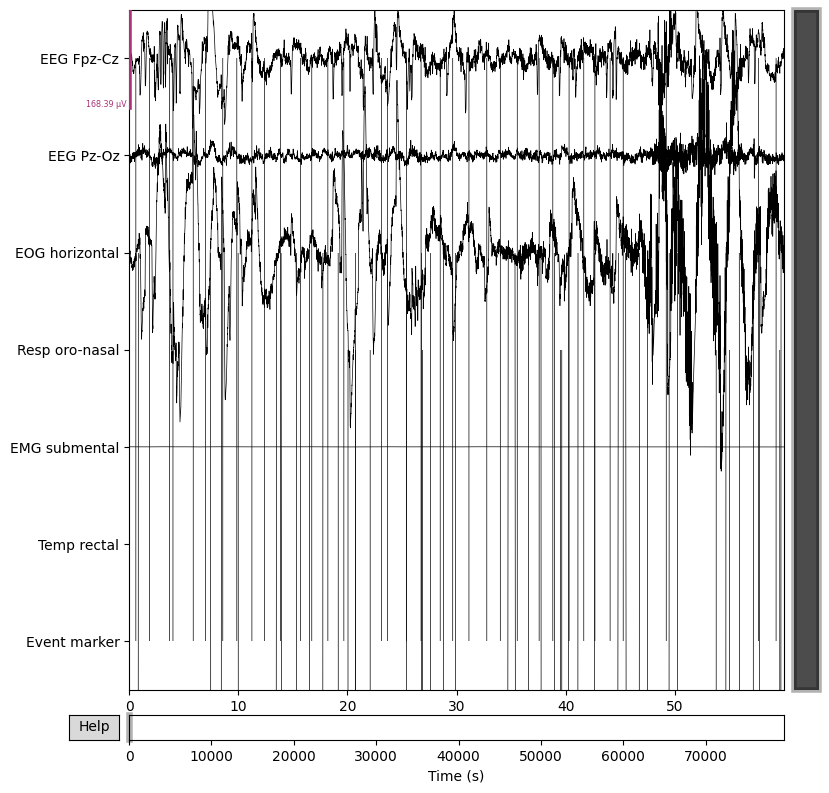

In [75]:
import mne
import matplotlib.pyplot as plt
import json

# Load one sample pair
with open(DATASET_DIR / "paired_files.json", "r") as f:
    pairs = json.load(f)["pairs"]

sample = pairs[0]
psg_path = sample["psg_file"]

# Load PSG
raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)

# Pick common EEG channels
channels_to_plot = [ch for ch in ["Fpz-Cz", "Pz-Oz"] if ch in raw.ch_names]
raw.pick_channels(channels_to_plot)

print("Plotting PSG channels:", channels_to_plot)

# Plot 60 seconds of EEG
raw.plot(
    start=0,
    duration=60,
    scalings="auto",
    title="Raw PSG EEG Signal (First 60 seconds)"
)


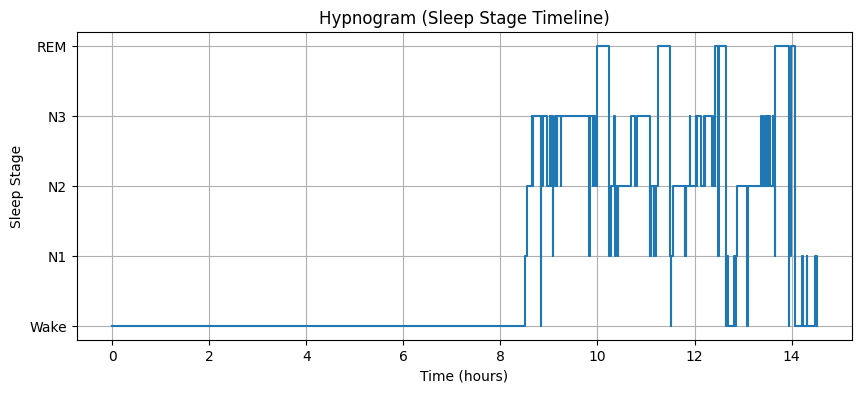

In [76]:
import numpy as np

hyp_path = sample["hypnogram_file"]
ann = mne.read_annotations(hyp_path)

STAGE_MAPPING = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
}

times = []
stages = []

for onset, duration, desc in zip(ann.onset, ann.duration, ann.description):
    if desc in STAGE_MAPPING:
        times.append(onset / 3600)  # convert to hours
        stages.append(STAGE_MAPPING[desc])

plt.figure(figsize=(10,4))
plt.step(times, stages, where="post")
plt.yticks(
    [0,1,2,3,4],
    ["Wake", "N1", "N2", "N3", "REM"]
)
plt.xlabel("Time (hours)")
plt.ylabel("Sleep Stage")
plt.title("Hypnogram (Sleep Stage Timeline)")
plt.grid(True)
plt.show()


In [80]:
import numpy as np

STAGE_MAPPING = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
}

hyp_times = []
hyp_stages = []

for onset, duration, desc in zip(ann.onset, ann.duration, ann.description):
    if desc not in STAGE_MAPPING:
        continue

    start = onset
    end = onset + duration

    # Keep only first 5 minutes (0–300s)
    if end < 0 or start > 300:
        continue

    hyp_times.extend([start, end])
    hyp_stages.extend([STAGE_MAPPING[desc], STAGE_MAPPING[desc]])


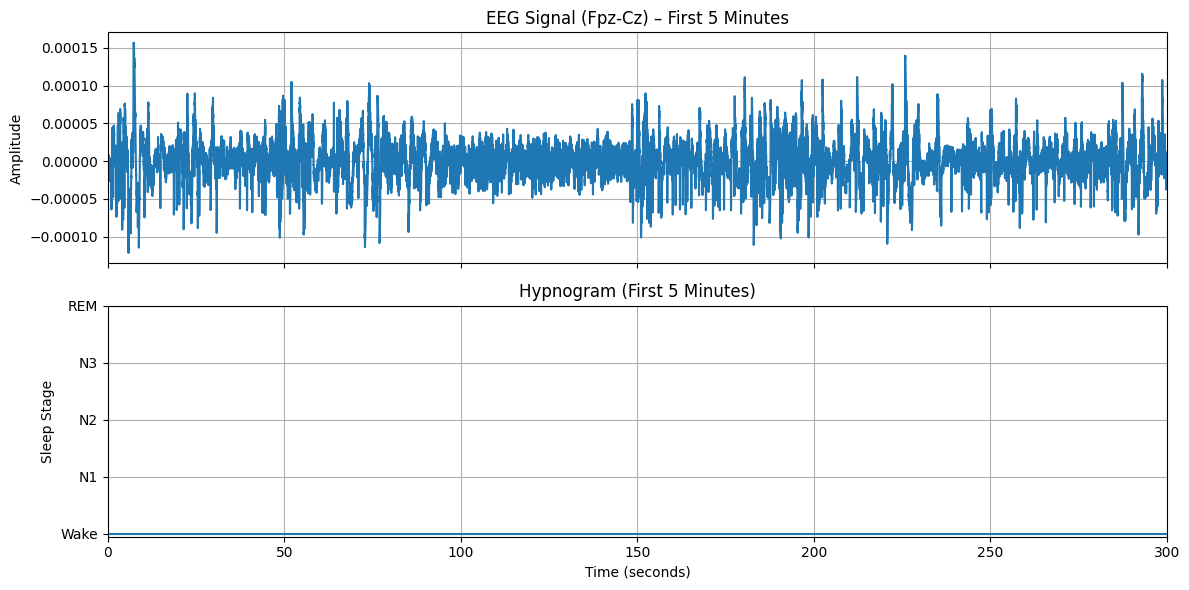

In [81]:
fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)

# -------- EEG (first 5 minutes) --------
data, times = raw[0, :30000]  # 300s × 100Hz
ax[0].plot(times, data[0])
ax[0].set_title("EEG Signal (Fpz-Cz) – First 5 Minutes")
ax[0].set_ylabel("Amplitude")
ax[0].grid(True)

# -------- Hypnogram (first 5 minutes) --------
ax[1].step(hyp_times, hyp_stages, where="post")
ax[1].set_yticks([0,1,2,3,4])
ax[1].set_yticklabels(["Wake","N1","N2","N3","REM"])
ax[1].set_xlim(0, 300)
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("Sleep Stage")
ax[1].set_title("Hypnogram (First 5 Minutes)")
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:



# ============================================
# STEP 5: EEG Preprocessing and Epoching
# ============================================
import numpy as np

OUTPUT_DIR = BASE_DIR / "preprocessed"
OUTPUT_DIR.mkdir(exist_ok=True)

EEG_CHANNELS = ['Fpz-Cz', 'Pz-Oz']
EOG_CHANNELS = ['EOG horizontal']
EMG_CHANNELS = ['EMG submental']

STAGE_MAPPING = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,  # merge N3/N4
    'Sleep stage R': 4
}

EPOCH_SEC = 30
TARGET_SFREQ = 100

X_list, y_list = [], []

for pair in tqdm(paired_data, desc="Preprocessing & Epoching"):
    rid = pair["record_id"]
    try:
        raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
        # Keep only selected channels
        chs = [ch for ch in raw.ch_names if ch in EEG_CHANNELS + EOG_CHANNELS + EMG_CHANNELS]
        raw.pick_channels(chs)
        # Resample to target SFREQ
        raw.resample(TARGET_SFREQ, npad="auto")
        # Filter
        raw.filter(0.5, 30, fir_design='firwin', verbose=False)
        data = raw.get_data()
        ann = mne.read_annotations(pair["hypnogram_file"])

        # Initialize labels
        labels = np.full(data.shape[1], -1)
        for onset, duration, desc in zip(ann.onset, ann.duration, ann.description):
            stage = STAGE_MAPPING.get(desc)
            if stage is not None:
                start = int(onset * TARGET_SFREQ)
                end = int((onset + duration) * TARGET_SFREQ)
                end = min(end, labels.shape[0])
                labels[start:end] = stage

        # Epoching
        n_epochs = data.shape[1] // (TARGET_SFREQ * EPOCH_SEC)
        for i in range(n_epochs):
            start = i * TARGET_SFREQ * EPOCH_SEC
            end = start + TARGET_SFREQ * EPOCH_SEC
            epoch_label = labels[start:end]
            if -1 in epoch_label:
                continue
            counts = np.bincount(epoch_label)
            final_label = np.argmax(counts)
            X_list.append(data[:, start:end])
            y_list.append(final_label)
    except Exception as e:
        print(f"Error in {rid}: {e}")

# Convert to NumPy arrays
X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.int64)

np.save(OUTPUT_DIR / "X.npy", X)
np.save(OUTPUT_DIR / "y.npy", y)
print("Preprocessing & epoching done. X shape:", X.shape, "y shape:", y.shape)

# ============================================
# STEP 6: Train/Validation/Test Split
# ============================================
from sklearn.model_selection import train_test_split

# Normalize per channel per epoch (vectorized)
X_norm = (X - X.mean(axis=2, keepdims=True)) / (X.std(axis=2, keepdims=True) + 1e-8)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_norm, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

np.save(OUTPUT_DIR / "X_train.npy", X_train)
np.save(OUTPUT_DIR / "y_train.npy", y_train)
np.save(OUTPUT_DIR / "X_val.npy", X_val)
np.save(OUTPUT_DIR / "y_val.npy", y_val)
np.save(OUTPUT_DIR / "X_test.npy", X_test)
np.save(OUTPUT_DIR / "y_test.npy", y_test)

print("Data splits saved!")

# ============================================
# STEP 7: PyTorch DataLoader Setup
# ============================================
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

def create_loader(X, y, shuffle=False):
    return DataLoader(
        TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
        batch_size=batch_size, shuffle=shuffle
    )

train_loader = create_loader(X_train, y_train, shuffle=True)
val_loader = create_loader(X_val, y_val, shuffle=False)
test_loader = create_loader(X_test, y_test, shuffle=False)

print("DataLoaders ready!")

# ============================================
# STEP 8: DeepSleepNet Definition
# ============================================
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight


class DeepSleepNet(nn.Module):
    def __init__(self, n_channels=2, n_classes=5):
        super().__init__()
        self.conv1 = nn.Conv1d(n_channels, 32, kernel_size=50, stride=6, padding=25)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=8, stride=1, padding=4)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(8)
        self.dropout = nn.Dropout(0.5)
        self.gru = nn.GRU(64, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128*2, n_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# ============================================
# STEP 9: Training Setup
# ============================================
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = DeepSleepNet(
    n_channels=X_train.shape[1],
    n_classes=5
).to(device)

class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.05   # helps generalization
)

optimizer = Adam(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=5,
    verbose=True
)


# ============================================
# STEP 10: Training Loop with Validation
# ============================================
n_epochs = 120
best_val_acc = 0.0
early_stop_counter = 0
early_stop_patience = 15

model_path = BASE_DIR / "best_deepsleepnet.pt"

for epoch in range(n_epochs):
    # ---------- TRAIN ----------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # 🔒 Gradient clipping (important for GRU)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ---------- VALIDATION ----------
    model.eval()
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            outputs = model(X_val_batch)
            val_correct += (outputs.argmax(1) == y_val_batch).sum().item()
            val_total += y_val_batch.size(0)

    val_acc = val_correct / val_total

    # LR scheduler step
    scheduler.step(val_acc)

    print(
        f"Epoch {epoch+1:03d}/{n_epochs} | "
        f"Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    # ---------- EARLY STOPPING ----------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), model_path)
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("🛑 Early stopping triggered!")
        break

print("✅ Training finished. Best Val Acc:", best_val_acc)





  Using cached numpy-1.26.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement torch==2.1.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1)
ERROR: No matching distribution found for torch==2.1.0
Base directory exists: /content/drive/MyDrive/sleep_edf_expanded
Dataset already exists, skipping download
Total paired records: 197, Missing PSG: 0, Missing Hyp: 0


Processing metadata:   0%|          | 0/197 [00:00<?, ?it/s]/tmp/ipython-input-295048501.py:107: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False)
/tmp/ipython-input-295048501.py:107: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False)
/tmp/ipython-input-295048501.py:107: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False)
Processing metadata:   1%|          | 1/197 [00:02<07:21,  2.25s/it]/tmp/ipython-input-295048501.py:107: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=Fal

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   1%|          | 1/197 [00:05<19:34,  5.99s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   1%|          | 2/197 [00:13<22:31,  6.93s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   2%|▏         | 3/197 [00:22<25:59,  8.04s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   2%|▏         | 4/197 [00:27<22:04,  6.86s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   3%|▎         | 5/197 [00:39<27:23,  8.56s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   3%|▎         | 6/197 [00:44<23:49,  7.48s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   4%|▎         | 7/197 [00:49<20:56,  6.61s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   4%|▍         | 8/197 [01:00<25:16,  8.02s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   5%|▍         | 9/197 [01:07<23:30,  7.50s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   5%|▌         | 10/197 [01:14<23:39,  7.59s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   6%|▌         | 11/197 [01:31<32:08, 10.37s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   6%|▌         | 12/197 [01:37<28:02,  9.10s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   7%|▋         | 13/197 [01:44<25:18,  8.25s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   7%|▋         | 14/197 [01:51<24:23,  8.00s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   8%|▊         | 15/197 [01:58<22:58,  7.57s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   8%|▊         | 16/197 [02:04<21:40,  7.19s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   9%|▊         | 17/197 [02:11<21:09,  7.05s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:   9%|▉         | 18/197 [02:19<22:13,  7.45s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  10%|▉         | 19/197 [02:30<25:14,  8.51s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  10%|█         | 20/197 [02:48<33:47, 11.45s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  11%|█         | 21/197 [02:52<27:08,  9.25s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  11%|█         | 22/197 [03:11<35:08, 12.05s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  12%|█▏        | 23/197 [03:27<38:07, 13.15s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  12%|█▏        | 24/197 [03:33<31:34, 10.95s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  13%|█▎        | 25/197 [03:39<27:38,  9.64s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  13%|█▎        | 26/197 [03:54<32:03, 11.25s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  14%|█▎        | 27/197 [04:00<27:13,  9.61s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  14%|█▍        | 28/197 [04:06<23:44,  8.43s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  15%|█▍        | 29/197 [04:10<20:17,  7.25s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  15%|█▌        | 30/197 [04:15<17:53,  6.43s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  16%|█▌        | 31/197 [04:21<17:40,  6.39s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  16%|█▌        | 32/197 [04:25<15:57,  5.80s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  17%|█▋        | 33/197 [04:30<15:10,  5.55s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  17%|█▋        | 34/197 [04:40<18:05,  6.66s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  18%|█▊        | 35/197 [04:46<17:57,  6.65s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  18%|█▊        | 36/197 [04:51<16:36,  6.19s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  19%|█▉        | 37/197 [04:56<15:34,  5.84s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  19%|█▉        | 38/197 [05:03<15:53,  6.00s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  20%|█▉        | 39/197 [05:07<14:28,  5.49s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  20%|██        | 40/197 [05:18<18:51,  7.21s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  21%|██        | 41/197 [05:23<16:52,  6.49s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  21%|██▏       | 42/197 [05:31<17:36,  6.82s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  22%|██▏       | 43/197 [05:39<18:51,  7.35s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  22%|██▏       | 44/197 [05:43<16:14,  6.37s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  23%|██▎       | 45/197 [05:48<15:06,  5.96s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  23%|██▎       | 46/197 [06:05<23:21,  9.28s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  24%|██▍       | 47/197 [06:10<19:43,  7.89s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  24%|██▍       | 48/197 [06:16<18:17,  7.36s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  25%|██▍       | 49/197 [06:22<17:10,  6.96s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  25%|██▌       | 50/197 [06:27<15:16,  6.23s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  26%|██▌       | 51/197 [06:32<14:25,  5.93s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  26%|██▋       | 52/197 [06:37<13:23,  5.54s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  27%|██▋       | 53/197 [06:41<12:22,  5.15s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  27%|██▋       | 54/197 [06:46<12:16,  5.15s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  28%|██▊       | 55/197 [06:51<12:13,  5.16s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  28%|██▊       | 56/197 [06:56<12:08,  5.17s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  29%|██▉       | 57/197 [07:02<12:12,  5.23s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  29%|██▉       | 58/197 [07:07<12:10,  5.26s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  30%|██▉       | 59/197 [07:14<13:28,  5.86s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  30%|███       | 60/197 [07:19<12:30,  5.48s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  31%|███       | 61/197 [07:23<11:46,  5.19s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  31%|███▏      | 62/197 [07:28<11:31,  5.12s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  32%|███▏      | 63/197 [07:33<11:04,  4.96s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  32%|███▏      | 64/197 [07:40<12:09,  5.49s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  33%|███▎      | 65/197 [07:45<11:47,  5.36s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  34%|███▎      | 66/197 [07:52<13:11,  6.04s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  34%|███▍      | 67/197 [07:57<12:06,  5.59s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  35%|███▍      | 68/197 [08:00<10:39,  4.95s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  35%|███▌      | 69/197 [08:05<10:25,  4.89s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  36%|███▌      | 70/197 [08:12<11:42,  5.54s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  36%|███▌      | 71/197 [08:18<12:00,  5.72s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  37%|███▋      | 72/197 [08:23<11:20,  5.44s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  37%|███▋      | 73/197 [08:28<10:41,  5.17s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  38%|███▊      | 74/197 [08:33<10:32,  5.14s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  38%|███▊      | 75/197 [08:37<09:55,  4.88s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  39%|███▊      | 76/197 [08:45<11:37,  5.77s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  39%|███▉      | 77/197 [08:51<11:57,  5.98s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  40%|███▉      | 78/197 [08:56<11:03,  5.58s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  40%|████      | 79/197 [09:00<10:22,  5.28s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  41%|████      | 80/197 [09:19<17:53,  9.18s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  41%|████      | 81/197 [09:31<19:18,  9.99s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  42%|████▏     | 82/197 [09:36<16:36,  8.67s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  42%|████▏     | 83/197 [09:44<15:54,  8.38s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  43%|████▎     | 84/197 [09:49<13:46,  7.31s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  43%|████▎     | 85/197 [09:54<12:36,  6.75s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  44%|████▎     | 86/197 [10:03<13:52,  7.50s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  44%|████▍     | 87/197 [10:08<12:13,  6.67s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  45%|████▍     | 88/197 [10:13<11:10,  6.15s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  45%|████▌     | 89/197 [10:21<11:49,  6.57s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  46%|████▌     | 90/197 [10:26<10:56,  6.13s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  46%|████▌     | 91/197 [10:32<10:42,  6.06s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  47%|████▋     | 92/197 [10:36<09:53,  5.65s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  47%|████▋     | 93/197 [10:41<09:04,  5.24s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  48%|████▊     | 94/197 [10:45<08:19,  4.85s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  48%|████▊     | 95/197 [10:49<08:04,  4.75s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  49%|████▊     | 96/197 [10:53<07:43,  4.59s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  49%|████▉     | 97/197 [10:57<07:24,  4.44s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  50%|████▉     | 98/197 [11:04<08:30,  5.15s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  50%|█████     | 99/197 [11:10<08:29,  5.20s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  51%|█████     | 100/197 [11:14<08:06,  5.02s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  51%|█████▏    | 101/197 [11:19<08:02,  5.02s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  52%|█████▏    | 102/197 [11:35<12:54,  8.16s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  52%|█████▏    | 103/197 [11:40<11:22,  7.26s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  53%|█████▎    | 104/197 [11:45<10:31,  6.79s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  53%|█████▎    | 105/197 [11:50<09:25,  6.14s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  54%|█████▍    | 106/197 [11:55<08:44,  5.77s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  54%|█████▍    | 107/197 [12:02<09:10,  6.11s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  55%|█████▍    | 108/197 [12:07<08:27,  5.70s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  55%|█████▌    | 109/197 [12:11<07:42,  5.26s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  56%|█████▌    | 110/197 [12:16<07:22,  5.08s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  56%|█████▋    | 111/197 [12:20<06:51,  4.79s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  57%|█████▋    | 112/197 [12:24<06:32,  4.62s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  57%|█████▋    | 113/197 [12:33<08:14,  5.89s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  58%|█████▊    | 114/197 [12:38<07:42,  5.58s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  58%|█████▊    | 115/197 [12:40<06:24,  4.69s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  59%|█████▉    | 116/197 [12:45<06:15,  4.64s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  59%|█████▉    | 117/197 [12:49<06:05,  4.56s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  60%|█████▉    | 118/197 [12:53<05:54,  4.49s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  60%|██████    | 119/197 [12:58<06:01,  4.64s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  61%|██████    | 120/197 [13:08<07:54,  6.16s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  61%|██████▏   | 121/197 [13:13<07:18,  5.77s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  62%|██████▏   | 122/197 [13:19<07:24,  5.93s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  62%|██████▏   | 123/197 [13:25<07:03,  5.72s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  63%|██████▎   | 124/197 [13:29<06:35,  5.42s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  63%|██████▎   | 125/197 [13:34<06:07,  5.10s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  64%|██████▍   | 126/197 [13:39<06:07,  5.17s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  64%|██████▍   | 127/197 [13:44<05:52,  5.04s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  65%|██████▍   | 128/197 [13:49<06:02,  5.25s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  65%|██████▌   | 129/197 [13:54<05:50,  5.16s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  66%|██████▌   | 130/197 [14:00<05:55,  5.30s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  66%|██████▋   | 131/197 [14:05<05:37,  5.11s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  67%|██████▋   | 132/197 [14:09<05:25,  5.01s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  68%|██████▊   | 133/197 [14:14<05:15,  4.92s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  68%|██████▊   | 134/197 [14:19<05:10,  4.93s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  69%|██████▊   | 135/197 [14:24<05:05,  4.94s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  69%|██████▉   | 136/197 [14:37<07:20,  7.23s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  70%|██████▉   | 137/197 [14:54<10:08, 10.15s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  70%|███████   | 138/197 [14:59<08:36,  8.76s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  71%|███████   | 139/197 [15:03<07:06,  7.36s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  71%|███████   | 140/197 [15:11<07:00,  7.37s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  72%|███████▏  | 141/197 [15:15<06:03,  6.49s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  72%|███████▏  | 142/197 [15:20<05:25,  5.91s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  73%|███████▎  | 143/197 [15:24<04:51,  5.39s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  73%|███████▎  | 144/197 [15:30<05:06,  5.78s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  74%|███████▎  | 145/197 [15:38<05:22,  6.19s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  74%|███████▍  | 146/197 [15:42<04:55,  5.79s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  75%|███████▍  | 147/197 [15:47<04:26,  5.34s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  75%|███████▌  | 148/197 [15:52<04:23,  5.37s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  76%|███████▌  | 149/197 [16:00<04:49,  6.02s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  76%|███████▌  | 150/197 [16:13<06:24,  8.19s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  77%|███████▋  | 151/197 [16:18<05:29,  7.16s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  77%|███████▋  | 152/197 [16:35<07:33, 10.08s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  78%|███████▊  | 153/197 [16:42<06:46,  9.24s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  78%|███████▊  | 154/197 [16:44<05:00,  6.98s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  79%|███████▊  | 155/197 [16:45<03:46,  5.38s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  79%|███████▉  | 156/197 [16:46<02:49,  4.13s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  80%|███████▉  | 157/197 [16:49<02:21,  3.53s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  80%|████████  | 158/197 [16:50<01:56,  2.98s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  81%|████████  | 159/197 [16:52<01:37,  2.57s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  81%|████████  | 160/197 [16:54<01:26,  2.33s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  82%|████████▏ | 161/197 [16:55<01:16,  2.13s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  82%|████████▏ | 162/197 [16:58<01:24,  2.40s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  83%|████████▎ | 163/197 [17:00<01:13,  2.15s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  83%|████████▎ | 164/197 [17:02<01:06,  2.01s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  84%|████████▍ | 165/197 [17:03<01:02,  1.95s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  84%|████████▍ | 166/197 [17:05<00:55,  1.80s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  85%|████████▍ | 167/197 [17:06<00:51,  1.70s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  85%|████████▌ | 168/197 [17:09<00:56,  1.94s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  86%|████████▌ | 169/197 [17:11<00:58,  2.09s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  86%|████████▋ | 170/197 [17:13<00:53,  2.00s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  87%|████████▋ | 171/197 [17:15<00:50,  1.93s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  87%|████████▋ | 172/197 [17:16<00:45,  1.83s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  88%|████████▊ | 173/197 [17:19<00:48,  2.01s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  88%|████████▊ | 174/197 [17:20<00:42,  1.86s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  89%|████████▉ | 175/197 [17:22<00:40,  1.86s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  89%|████████▉ | 176/197 [17:24<00:40,  1.91s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  90%|████████▉ | 177/197 [17:26<00:37,  1.86s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  90%|█████████ | 178/197 [17:28<00:34,  1.81s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  91%|█████████ | 179/197 [17:29<00:31,  1.72s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  91%|█████████▏| 180/197 [17:32<00:34,  2.05s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  92%|█████████▏| 181/197 [17:33<00:29,  1.86s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  92%|█████████▏| 182/197 [17:35<00:26,  1.79s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  93%|█████████▎| 183/197 [17:37<00:25,  1.80s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  93%|█████████▎| 184/197 [17:38<00:22,  1.72s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  94%|█████████▍| 185/197 [17:40<00:20,  1.70s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  94%|█████████▍| 186/197 [17:42<00:18,  1.65s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  95%|█████████▍| 187/197 [17:44<00:18,  1.82s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  95%|█████████▌| 188/197 [17:45<00:15,  1.67s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  96%|█████████▌| 189/197 [17:47<00:12,  1.62s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  96%|█████████▋| 190/197 [17:48<00:10,  1.56s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  97%|█████████▋| 191/197 [17:50<00:09,  1.54s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  97%|█████████▋| 192/197 [17:51<00:08,  1.65s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  98%|█████████▊| 193/197 [17:53<00:06,  1.73s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  98%|█████████▊| 194/197 [17:55<00:05,  1.71s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  99%|█████████▉| 195/197 [17:57<00:03,  1.78s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching:  99%|█████████▉| 196/197 [17:59<00:01,  1.88s/it]/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-295048501.py:157: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


Preprocessing & Epoching: 100%|██████████| 197/197 [18:01<00:00,  5.49s/it]


Preprocessing & epoching done. X shape: (457652, 2, 3000) y shape: (457652,)
Data splits saved!
DataLoaders ready!
Using device: cuda


NameError: name 'compute_class_weight' is not defined

In [ ]:
# ============================================
# STEP 8: DeepSleepNet Definition
# ============================================
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight


class DeepSleepNet(nn.Module):
    def __init__(self, n_channels=2, n_classes=5):
        super().__init__()
        self.conv1 = nn.Conv1d(n_channels, 32, kernel_size=50, stride=6, padding=25)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=8, stride=1, padding=4)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(8)
        self.dropout = nn.Dropout(0.5)
        self.gru = nn.GRU(64, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128*2, n_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
# ============================================
# STEP 9: Training Setup
# ============================================
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = DeepSleepNet(
    n_channels=X_train.shape[1],
    n_classes=5
).to(device)

class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.05   # helps generalization
)

optimizer = Adam(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)


scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=5
)



Using device: cuda


In [ ]:
# ============================================
# STEP 10: Training Loop with Validation
# ============================================
n_epochs = 120
best_val_acc = 0.0
early_stop_counter = 0
early_stop_patience = 15

model_path = BASE_DIR / "best_deepsleepnet.pt"

for epoch in range(n_epochs):
    # ---------- TRAIN ----------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # 🔒 Gradient clipping (important for GRU)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ---------- VALIDATION ----------
    model.eval()
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            outputs = model(X_val_batch)
            val_correct += (outputs.argmax(1) == y_val_batch).sum().item()
            val_total += y_val_batch.size(0)

    val_acc = val_correct / val_total

    # LR scheduler step
    scheduler.step(val_acc)

    print(
        f"Epoch {epoch+1:03d}/{n_epochs} | "
        f"Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    # ---------- EARLY STOPPING ----------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), model_path)
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("🛑 Early stopping triggered!")
        break

print("✅ Training finished. Best Val Acc:", best_val_acc)



Epoch 001/120 | Loss: 0.9612 | Train Acc: 0.8104 | Val Acc: 0.8006
Epoch 002/120 | Loss: 0.9582 | Train Acc: 0.8113 | Val Acc: 0.8209
Epoch 003/120 | Loss: 0.9544 | Train Acc: 0.8124 | Val Acc: 0.7992
Epoch 004/120 | Loss: 0.9512 | Train Acc: 0.8138 | Val Acc: 0.8155
Epoch 005/120 | Loss: 0.9484 | Train Acc: 0.8142 | Val Acc: 0.8034
Epoch 006/120 | Loss: 0.9451 | Train Acc: 0.8157 | Val Acc: 0.8172
Epoch 007/120 | Loss: 0.9423 | Train Acc: 0.8175 | Val Acc: 0.8108
Epoch 008/120 | Loss: 0.9391 | Train Acc: 0.8188 | Val Acc: 0.8270
Epoch 009/120 | Loss: 0.9371 | Train Acc: 0.8193 | Val Acc: 0.8079
Epoch 010/120 | Loss: 0.9363 | Train Acc: 0.8204 | Val Acc: 0.8271
Epoch 011/120 | Loss: 0.9335 | Train Acc: 0.8212 | Val Acc: 0.8224
Epoch 012/120 | Loss: 0.9313 | Train Acc: 0.8224 | Val Acc: 0.8174
Epoch 013/120 | Loss: 0.9296 | Train Acc: 0.8236 | Val Acc: 0.8179
Epoch 014/120 | Loss: 0.9266 | Train Acc: 0.8251 | Val Acc: 0.8147
Epoch 015/120 | Loss: 0.9263 | Train Acc: 0.8245 | Val Acc: 0.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, f1_score


model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_val_batch, y_val_batch in val_loader:
        X_val_batch = X_val_batch.to(device)
        outputs = model(X_val_batch)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y_val_batch.numpy())

val_acc = accuracy_score(all_labels, all_preds)
val_f1 = f1_score(all_labels, all_preds, average="macro")

print(
    f"Epoch {epoch+1}/{n_epochs} | "
    f"Loss: {train_loss:.4f} | "
    f"Train Acc: {train_acc:.4f} | "
    f"Val Acc: {val_acc:.4f} | "
    f"Val Macro-F1: {val_f1:.4f}"
)

# Save best model based on Macro-F1 (better than accuracy)
if val_f1 > best_val_acc:
    best_val_acc = val_f1
    torch.save(model.state_dict(), model_path)


Epoch 48/120 | Loss: 0.8676 | Train Acc: 0.8482 | Val Acc: 0.8305 | Val Macro-F1: 0.7023


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    cohen_kappa_score,
    classification_report,
    confusion_matrix
)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

# Core metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average="macro")
kappa = cohen_kappa_score(all_labels, all_preds)

print(f"Accuracy     : {acc:.4f}")
print(f"Macro-F1     : {macro_f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")


Accuracy     : 0.8426
Macro-F1     : 0.7112
Cohen's Kappa: 0.7281


In [ ]:
stage_names = ["Wake", "N1", "N2", "N3", "REM"]

print(
    classification_report(
        all_labels,
        all_preds,
        target_names=stage_names,
        digits=4
    )
)


              precision    recall  f1-score   support

        Wake     0.9867    0.9370    0.9612     43478
          N1     0.3265    0.7278    0.4508      3777
          N2     0.8896    0.5751    0.6986     13347
          N3     0.5850    0.8657    0.6982      2918
         REM     0.6932    0.8103    0.7472      5128

    accuracy                         0.8426     68648
   macro avg     0.6962    0.7832    0.7112     68648
weighted avg     0.8925    0.8426    0.8549     68648



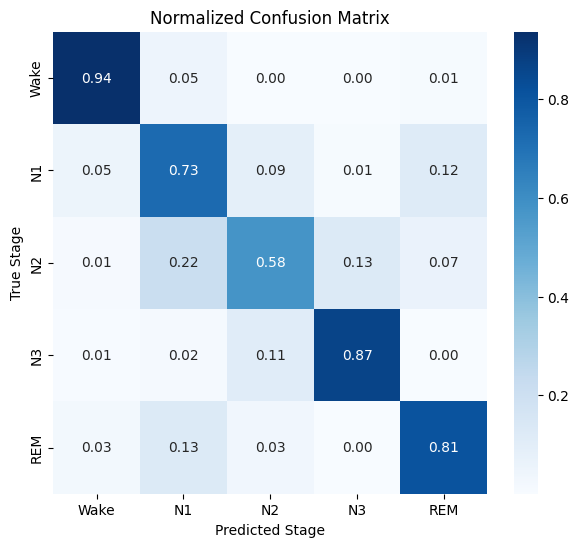

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=stage_names,
    yticklabels=stage_names
)
plt.xlabel("Predicted Stage")
plt.ylabel("True Stage")
plt.title("Normalized Confusion Matrix")
plt.show()


In [ ]:
import numpy as np

def bootstrap_ci(y_true, y_pred, metric_fn, n_boot=1000):
    scores = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        scores.append(metric_fn(y_true[idx], y_pred[idx]))

    return np.percentile(scores, [2.5, 97.5])

ci_acc = bootstrap_ci(all_labels, all_preds, accuracy_score)
ci_f1 = bootstrap_ci(
    all_labels,
    all_preds,
    lambda y, p: f1_score(y, p, average="macro")
)

print(f"Accuracy  CI : {ci_acc}")
print(f"Macro-F1 CI : {ci_f1}")


Accuracy  CI : [0.83981981 0.84545799]
Macro-F1 CI : [0.70655703 0.71592902]


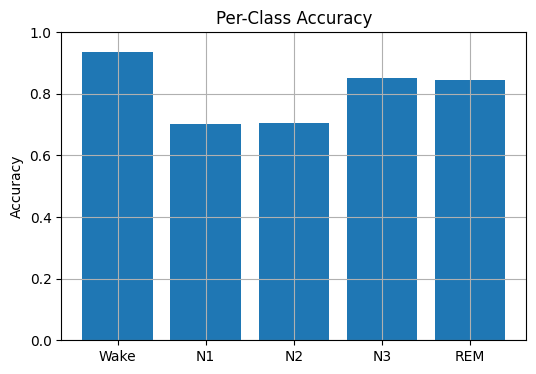

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(6,4))
plt.bar(stage_names, per_class_acc)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGNet_GRU(nn.Module):
    def __init__(self, n_channels=2, n_classes=5):
        super().__init__()

        # EEGNet block
        self.conv1 = nn.Conv1d(
            in_channels=n_channels,
            out_channels=16,
            kernel_size=64,
            padding=32,
            bias=False
        )
        self.bn1 = nn.BatchNorm1d(16)

        self.depthwise = nn.Conv1d(
            in_channels=16,
            out_channels=32,
            kernel_size=1,
            groups=16,
            bias=False
        )
        self.bn2 = nn.BatchNorm1d(32)

        self.pool1 = nn.AvgPool1d(4)
        self.dropout1 = nn.Dropout(0.5)

        # BiGRU
        self.gru = nn.GRU(
            input_size=32,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(256, n_classes)

    def forward(self, x):
        # x: (B, C, T)
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.depthwise(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # GRU expects (B, T, F)
        x = x.permute(0, 2, 1)
        x, _ = self.gru(x)
        x = x[:, -1, :]
        return self.fc(x)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = EEGNet_GRU(
    n_channels=X_train.shape[1],
    n_classes=5
).to(device)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.05
)

optimizer = Adam(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=5
)

model_path = BASE_DIR / "best_eegnet_gru.pt"


Using device: cuda


In [ ]:
n_epochs = 120
best_val_f1 = 0.0
early_stop_counter = 0
early_stop_patience = 15

for epoch in range(n_epochs):
    # ---------- TRAIN ----------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ---------- VALIDATION ----------
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch = X_val_batch.to(device)
            outputs = model(X_val_batch)
            preds = outputs.argmax(1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(y_val_batch.numpy())

    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average="macro")

    scheduler.step(val_f1)
    current_lr = optimizer.param_groups[0]["lr"]

    print(
        f"Epoch {epoch+1:03d}/{n_epochs} | "
        f"Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Val Macro-F1: {val_f1:.4f} | "
        f"LR: {current_lr:.6f}"
    )

    # ---------- SAVE BEST ----------
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stop_counter = 0
        torch.save(model.state_dict(), model_path)
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("🛑 Early stopping triggered")
        break

print("✅ Training complete. Best Val Macro-F1:", best_val_f1)


Epoch 001/120 | Loss: 1.4444 | Train Acc: 0.5528 | Val Acc: 0.7371 | Val Macro-F1: 0.5696 | LR: 0.000300
Epoch 002/120 | Loss: 1.1844 | Train Acc: 0.7320 | Val Acc: 0.7638 | Val Macro-F1: 0.6020 | LR: 0.000300
Epoch 003/120 | Loss: 1.1012 | Train Acc: 0.7661 | Val Acc: 0.7730 | Val Macro-F1: 0.6002 | LR: 0.000300
Epoch 004/120 | Loss: 1.0633 | Train Acc: 0.7794 | Val Acc: 0.7728 | Val Macro-F1: 0.6028 | LR: 0.000300
Epoch 005/120 | Loss: 1.0413 | Train Acc: 0.7858 | Val Acc: 0.7931 | Val Macro-F1: 0.6310 | LR: 0.000300
Epoch 006/120 | Loss: 1.0232 | Train Acc: 0.7915 | Val Acc: 0.7965 | Val Macro-F1: 0.6437 | LR: 0.000300
Epoch 007/120 | Loss: 1.0147 | Train Acc: 0.7940 | Val Acc: 0.7929 | Val Macro-F1: 0.6300 | LR: 0.000300
Epoch 008/120 | Loss: 1.0057 | Train Acc: 0.7973 | Val Acc: 0.7847 | Val Macro-F1: 0.6340 | LR: 0.000300
Epoch 009/120 | Loss: 0.9997 | Train Acc: 0.8000 | Val Acc: 0.7855 | Val Macro-F1: 0.6324 | LR: 0.000300
Epoch 010/120 | Loss: 0.9919 | Train Acc: 0.8028 | Val 

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, f1_score


model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_val_batch, y_val_batch in val_loader:
        X_val_batch = X_val_batch.to(device)
        outputs = model(X_val_batch)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y_val_batch.numpy())

val_acc = accuracy_score(all_labels, all_preds)
val_f1 = f1_score(all_labels, all_preds, average="macro")

print(
    f"Epoch {epoch+1}/{n_epochs} | "
    f"Loss: {train_loss:.4f} | "
    f"Train Acc: {train_acc:.4f} | "
    f"Val Acc: {val_acc:.4f} | "
    f"Val Macro-F1: {val_f1:.4f}"
)

# Save best model based on Macro-F1 (better than accuracy)
if val_f1 > best_val_acc:
    best_val_acc = val_f1
    torch.save(model.state_dict(), model_path)


Epoch 48/120 | Loss: 0.8999 | Train Acc: 0.8353 | Val Acc: 0.8281 | Val Macro-F1: 0.6877


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    cohen_kappa_score,
    classification_report,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

print("Accuracy     :", accuracy_score(all_labels, all_preds))
print("Macro-F1     :", f1_score(all_labels, all_preds, average="macro"))
print("Cohen Kappa  :", cohen_kappa_score(all_labels, all_preds))

stage_names = ["Wake", "N1", "N2", "N3", "REM"]
print(classification_report(all_labels, all_preds, target_names=stage_names))


Accuracy     : 0.8281231791166531
Macro-F1     : 0.6877424362561076
Cohen Kappa  : 0.7025499930540211
              precision    recall  f1-score   support

        Wake       0.98      0.93      0.95     43478
          N1       0.30      0.73      0.43      3777
          N2       0.87      0.57      0.69     13347
          N3       0.54      0.88      0.67      2918
         REM       0.73      0.67      0.70      5128

    accuracy                           0.83     68648
   macro avg       0.68      0.76      0.69     68648
weighted avg       0.88      0.83      0.84     68648



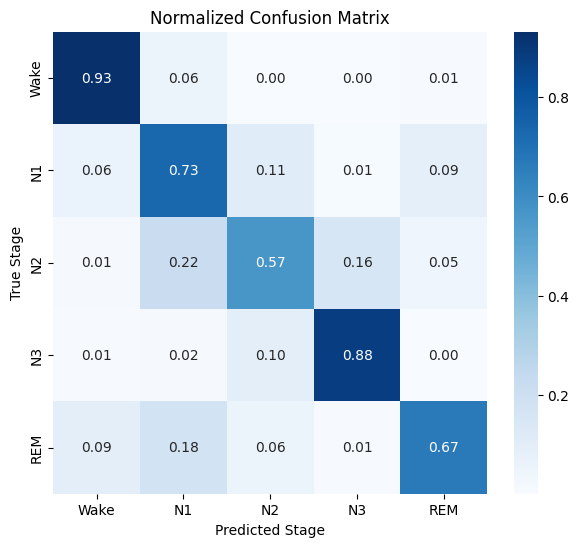

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=stage_names,
    yticklabels=stage_names
)
plt.xlabel("Predicted Stage")
plt.ylabel("True Stage")
plt.title("Normalized Confusion Matrix")
plt.show()


In [ ]:
import numpy as np

def bootstrap_ci(y_true, y_pred, metric_fn, n_boot=1000):
    scores = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        scores.append(metric_fn(y_true[idx], y_pred[idx]))

    return np.percentile(scores, [2.5, 97.5])

ci_acc = bootstrap_ci(all_labels, all_preds, accuracy_score)
ci_f1 = bootstrap_ci(
    all_labels,
    all_preds,
    lambda y, p: f1_score(y, p, average="macro")
)

print(f"Accuracy  CI : {ci_acc}")
print(f"Macro-F1 CI : {ci_f1}")


Accuracy  CI : [0.82509287 0.83077475]
Macro-F1 CI : [0.6828848  0.69246228]


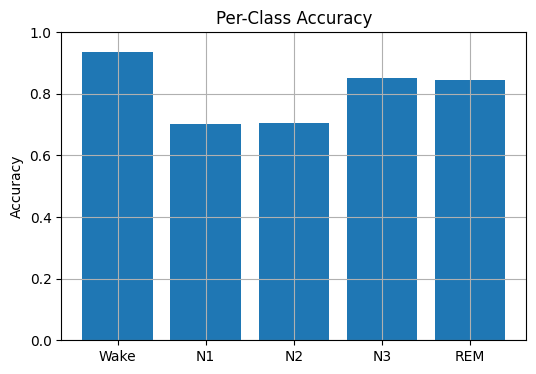

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(6,4))
plt.bar(stage_names, per_class_acc)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.grid(True)
plt.show()


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, L, D)
        L = x.size(1)
        return x + self.pe[:, :L, :]

class CNNTransformerSleepNet(nn.Module):
    def __init__(
        self,
        n_channels=2,
        n_classes=5,
        d_model=128,
        nhead=8,
        num_layers=4,
        dim_feedforward=256,
        dropout=0.3,
    ):
        super().__init__()

        # CNN front-end (feature extractor)
        self.cnn = nn.Sequential(
            nn.Conv1d(n_channels, 64, kernel_size=25, stride=2, padding=12, bias=False),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=4),

            nn.Conv1d(64, d_model, kernel_size=15, stride=2, padding=7, bias=False),
            nn.BatchNorm1d(d_model),
            nn.ELU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Dropout(dropout),
        )

        self.pos = PositionalEncoding(d_model=d_model, max_len=2000)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,     # IMPORTANT: keeps shape (B, L, D)
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_classes)
        )

    def forward(self, x):
        # x: (B, C, T)
        x = self.cnn(x)              # (B, D, L)
        x = x.permute(0, 2, 1)       # (B, L, D)
        x = self.pos(x)              # (B, L, D)
        x = self.transformer(x)      # (B, L, D)
        x = x.mean(dim=1)            # global average over time tokens -> (B, D)
        return self.head(x)          # (B, n_classes)


In [ ]:
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = CNNTransformerSleepNet(
    n_channels=X_train.shape[1],
    n_classes=5,
    d_model=128,
    nhead=8,
    num_layers=4,
    dim_feedforward=256,
    dropout=0.3
).to(device)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.05
)

optimizer = AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=5
)

model_path = BASE_DIR / "best_cnn_transformer.pt"


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

n_epochs = 120
best_val_f1 = 0.0
early_stop_counter = 0
early_stop_patience = 15

for epoch in range(n_epochs):
    # ---- TRAIN ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ---- VAL ----
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch = X_val_batch.to(device)
            outputs = model(X_val_batch)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_val_batch.numpy())

    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average="macro")

    scheduler.step(val_f1)
    lr = optimizer.param_groups[0]["lr"]

    print(
        f"Epoch {epoch+1:03d}/{n_epochs} | "
        f"Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Val Macro-F1: {val_f1:.4f} | "
        f"LR: {lr:.6f}"
    )

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stop_counter = 0
        torch.save(model.state_dict(), model_path)
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("🛑 Early stopping triggered")
        break

print("✅ Training complete. Best Val Macro-F1:", best_val_f1)
print("Best model saved at:", model_path)


Epoch 001/120 | Loss: 1.0458 | Train Acc: 0.7747 | Val Acc: 0.7927 | Val Macro-F1: 0.6434 | LR: 0.000300
Epoch 002/120 | Loss: 0.9752 | Train Acc: 0.8045 | Val Acc: 0.8000 | Val Macro-F1: 0.6636 | LR: 0.000300
Epoch 003/120 | Loss: 0.9535 | Train Acc: 0.8122 | Val Acc: 0.8119 | Val Macro-F1: 0.6770 | LR: 0.000300
Epoch 004/120 | Loss: 0.9374 | Train Acc: 0.8196 | Val Acc: 0.8151 | Val Macro-F1: 0.6837 | LR: 0.000300
Epoch 005/120 | Loss: 0.9272 | Train Acc: 0.8238 | Val Acc: 0.8432 | Val Macro-F1: 0.7030 | LR: 0.000300
Epoch 006/120 | Loss: 0.9174 | Train Acc: 0.8279 | Val Acc: 0.8376 | Val Macro-F1: 0.7052 | LR: 0.000300
Epoch 007/120 | Loss: 0.9098 | Train Acc: 0.8312 | Val Acc: 0.8233 | Val Macro-F1: 0.6928 | LR: 0.000300
Epoch 008/120 | Loss: 0.9011 | Train Acc: 0.8344 | Val Acc: 0.8451 | Val Macro-F1: 0.7163 | LR: 0.000300
Epoch 009/120 | Loss: 0.8966 | Train Acc: 0.8362 | Val Acc: 0.8457 | Val Macro-F1: 0.7139 | LR: 0.000300
Epoch 010/120 | Loss: 0.8908 | Train Acc: 0.8387 | Val 

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, f1_score


model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_val_batch, y_val_batch in val_loader:
        X_val_batch = X_val_batch.to(device)
        outputs = model(X_val_batch)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y_val_batch.numpy())

val_acc = accuracy_score(all_labels, all_preds)
val_f1 = f1_score(all_labels, all_preds, average="macro")

print(
    f"Epoch {epoch+1}/{n_epochs} | "
    f"Loss: {train_loss:.4f} | "
    f"Train Acc: {train_acc:.4f} | "
    f"Val Acc: {val_acc:.4f} | "
    f"Val Macro-F1: {val_f1:.4f}"
)

# Save best model based on Macro-F1 (better than accuracy)
if val_f1 > best_val_acc:
    best_val_acc = val_f1
    torch.save(model.state_dict(), model_path)


Epoch 72/120 | Loss: 0.7348 | Train Acc: 0.8926 | Val Acc: 0.8711 | Val Macro-F1: 0.7549


🧪 TEST RESULTS — CNN+Transformer
Accuracy     : 0.8670
Macro-F1     : 0.7497
Cohen Kappa  : 0.7697

Classification Report:

              precision    recall  f1-score   support

        Wake     0.9932    0.9347    0.9630     43479
          N1     0.3647    0.7023    0.4801      3776
          N2     0.8800    0.7056    0.7833     13348
          N3     0.6605    0.8513    0.7438      2918
         REM     0.7218    0.8440    0.7781      5127

    accuracy                         0.8670     68648
   macro avg     0.7240    0.8076    0.7497     68648
weighted avg     0.9022    0.8670    0.8784     68648



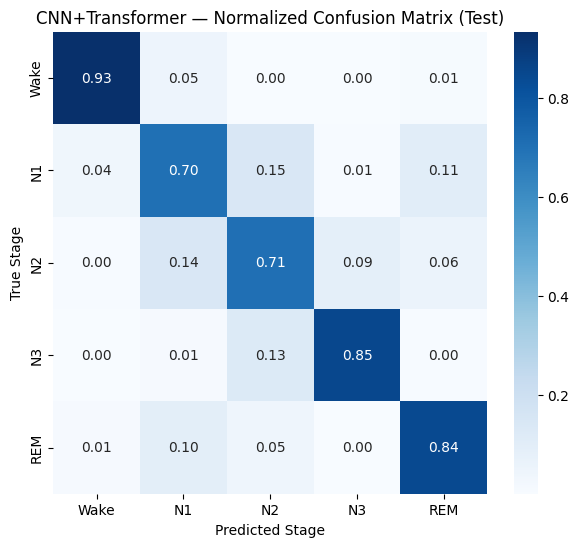

In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load best model
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device).eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average="macro")
kappa = cohen_kappa_score(all_labels, all_preds)

print("🧪 TEST RESULTS — CNN+Transformer")
print(f"Accuracy     : {acc:.4f}")
print(f"Macro-F1     : {macro_f1:.4f}")
print(f"Cohen Kappa  : {kappa:.4f}")

stage_names = ["Wake", "N1", "N2", "N3", "REM"]
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=stage_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=stage_names, yticklabels=stage_names)
plt.xlabel("Predicted Stage")
plt.ylabel("True Stage")
plt.title("CNN+Transformer — Normalized Confusion Matrix (Test)")
plt.show()


In [ ]:
import numpy as np

def bootstrap_ci(y_true, y_pred, metric_fn, n_boot=1000):
    scores = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        scores.append(metric_fn(y_true[idx], y_pred[idx]))

    return np.percentile(scores, [2.5, 97.5])

ci_acc = bootstrap_ci(all_labels, all_preds, accuracy_score)
ci_f1 = bootstrap_ci(
    all_labels,
    all_preds,
    lambda y, p: f1_score(y, p, average="macro")
)

print(f"Accuracy  CI : {ci_acc}")
print(f"Macro-F1 CI : {ci_f1}")


Accuracy  CI : [0.86449714 0.86934871]
Macro-F1 CI : [0.74507197 0.75396799]


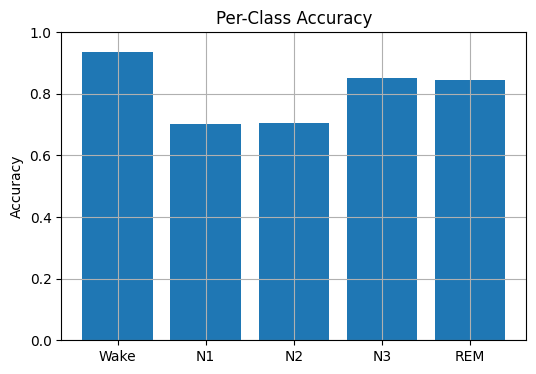

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(6,4))
plt.bar(stage_names, per_class_acc)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.grid(True)
plt.show()


In [ ]:
!pip install shap --quiet


In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from pathlib import Path

OUTPUT_DIR = Path("/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed")

# Load only a subset (e.g., first 1000 samples)
X = np.load(OUTPUT_DIR / "X.npy")[:1000]  # first 1000 samples
y = np.load(OUTPUT_DIR / "y.npy")[:1000]

print("Subset X shape:", X.shape, "y shape:", y.shape)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test, dtype=torch.long).to(device)


In [ ]:
X_background_t = X_train_t[:50]  # background for SHAP
X_sample_t     = X_test_t[:10]   # samples to explain


In [ ]:
import shap

# Ensure model is in evaluation mode
model.eval()

# Create GradientExplainer
explainer = shap.GradientExplainer(model, X_background_t)

# Compute SHAP values for sample
shap_values = explainer.shap_values(X_sample_t)
print("Number of classes:", len(shap_values))
print("SHAP shape for class 0:", shap_values[0].shape)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

channels = ["C3", "C4", "O1", "O2"]  # replace with your EEG channel names

# For class 0
shap_class0 = shap_values[0]  # shape: (n_samples, n_channels, n_timepoints)
shap_per_channel = np.mean(np.abs(shap_class0), axis=(0,2))  # mean over samples and timepoints

plt.figure(figsize=(8,4))
plt.bar(channels, shap_per_channel)
plt.title("Mean absolute SHAP values per channel (class 0)")
plt.ylabel("Mean |SHAP value|")
plt.show()


In [ ]:
# Average over channels and timepoints for each class
shap_per_class = [np.mean(np.abs(shap_values[c])) for c in range(len(shap_values))]

plt.figure(figsize=(6,4))
plt.bar(range(len(shap_per_class)), shap_per_class)
plt.xticks(range(len(shap_per_class)), [f"Class {i}" for i in range(len(shap_per_class))])
plt.title("Mean absolute SHAP values per class")
plt.ylabel("Mean |SHAP value|")
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Use class 0 as example
shap_class0 = shap_values[0]  # shape: (n_samples, n_channels, n_timepoints)

# Average over samples
shap_avg = np.mean(np.abs(shap_class0), axis=0)  # shape: (n_channels, n_timepoints)

n_channels, n_timepoints = shap_avg.shape
time = np.arange(n_timepoints)
channels = ["C3", "C4", "O1", "O2"]  # adjust according to your EEG channels

# 3D plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for time and channels
time_grid, channel_grid = np.meshgrid(time, np.arange(n_channels))

# Plot surface
surf = ax.plot_surface(time_grid, channel_grid, shap_avg, cmap='viridis')
ax.set_yticks(np.arange(n_channels))
ax.set_yticklabels(channels)
ax.set_xlabel("Timepoints")
ax.set_ylabel("Channels")
ax.set_zlabel("Mean |SHAP value|")
ax.set_title("3D SHAP: Channels × Timepoints (Class 0)")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [ ]:
# Validation
model.eval()
val_correct, val_total = 0, 0
     with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            outputs = model(X_val_batch)
            val_correct += (outputs.argmax(1) == y_val_batch).sum().item()
            val_total += y_val_batch.size(0)
    val_acc = val_correct / val_total
    print(f"Epoch {epoch+1}/{n_epochs} — Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)

        print("Training complete. Best model saved at:", model_path)

# ============================================
# STEP 11: Evaluation
# ============================================
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device).eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

print("Validation Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import plotly.graph_objects as go

# shap_class0: shape (n_samples, n_channels, n_timepoints)
shap_class0 = shap_values[0]

# Average over samples
shap_avg = np.mean(np.abs(shap_class0), axis=0)  # shape: (n_channels, n_timepoints)

n_channels, n_timepoints = shap_avg.shape
time = np.arange(n_timepoints)
channels = ["C3", "C4", "O1", "O2"]  # adjust according to your EEG channels

# Create meshgrid
time_grid, channel_grid = np.meshgrid(time, np.arange(n_channels))

# Plotly surface
fig = go.Figure(data=[go.Surface(
    z=shap_avg,
    x=time_grid,
    y=channel_grid,
    colorscale='Viridis',
    colorbar=dict(title='Mean |SHAP|')
)])

fig.update_layout(
    title='Interactive 3D SHAP: Channels × Timepoints (Class 0)',
    scene=dict(
        xaxis_title='Timepoints',
        yaxis_title='Channels',
        yaxis=dict(tickvals=list(range(n_channels)), ticktext=channels),
        zaxis_title='Mean |SHAP value|'
    ),
    autosize=True,
    width=900,
    height=600
)

fig.show()
